## Convolutional Neural Networks

We explore building a CNN with PyTorch to recognize digits.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from time import time
import numpy as np

import matplotlib.pyplot as plt


torch.manual_seed(1)
use_cuda = not False and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [3]:
 kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
# Load MNIST dataset: this data is normalized and then loaded into a tensor
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=200, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                   transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=100, shuffle=True)

### Build the Network

This network has four layers (two hidden). The first two are convolution and the next two are linear, fully connected layers. The activation function for the first three layers is Relu and the last one is SoftMax.

### Train the Network

We training the model with the data available.

In [31]:
def train(model, device, train_loader, optimizer, epoch):
    # initiate the training process
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data   = data.to(device), 
        target = target.to(device)
        optimizer.zero_grad() # initialize the optimizer
        # calculate the output for the input data, based on the current model
        output = model(data)
        # take care of the backward propagation
        loss = F.nll_loss(output, target) # calculate the loss — by comparing the output and the target
        loss.backward() 
        optimizer.step() # update the model based on this loss
        
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### Test the Network

Similarly, we have a test method that verifies the performance of the network based on the given test data set. The steps basicall yloops over the entire test data, to find out the loss over all. It counts the number of correct and incorrect predictions and the prints a formatted log.

In [32]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data   = data.to(device), 
            target = target.to(device)
            
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True) 
            
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
# define data tranformation to perform on images
mean = 0.5
std = 0.5
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean,), (std,)),
                              ])

Tranformation converts the image into numbers, that are understandable by the system. It separates the image into three color channels (separate images): red, green & blue. Then it converts the pixels of each image to the brightness of their color between 0 and 255. These values are then scaled down to a range between 0 and 1. Also, normalize the tensor with a mean and standard deviation which goes as the two parameters respectively.

In [37]:
# download the data sets, shuffle them and transform each of them
PATH_TO_STORE_TRAINSET = '../data'
PATH_TO_STORE_TESTSET  = '../data'
batch_size = 64

# MNIST dataset
trainset = datasets.MNIST(PATH_TO_STORE_TRAINSET, download=True, 
                          train=True,  transform=transform)
valset   = datasets.MNIST(PATH_TO_STORE_TESTSET,  download=True, 
                          train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, **kwargs)
valloader   = torch.utils.data.DataLoader(valset,   batch_size=batch_size, 
                                          shuffle=True)

Now, batch size is the number of images we want to read in one go.

### Exploratory data analysis on image data

In [38]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


There are 64 images in each batch and each image has a dimension of 28 x 28 pixels.

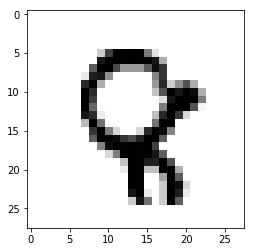

In [39]:
# let's display the first image from the training set
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

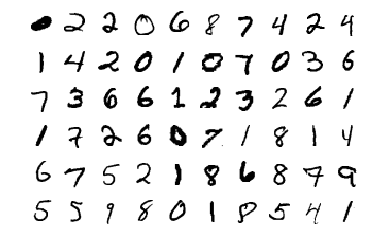

In [40]:
# Now, let's display several images:generate a grid of images in a random order
figure = plt.figure()
num_of_images = 60

for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Build The Neural Network

In [41]:
# Set of hyperparameters
input_size = 784 # 784 units in the first layer we flatten out each image (28 x 28 = 784)
hidden_sizes = [128, 64]
output_size = 10
learning_rate = 0.001
num_epochs = 5
num_classes = 10

# wraps the layers in the network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


There are 3 linear layers with ReLU activation (allows positive values to pass through, whereas negative values are set to zero). The output layer is a linear layer with LogSoftmax (logarithm of a Softmax) activation because this is a classification problem.

In [ ]:
# extract next batch of images
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

In [42]:
# define the negative log-likelihood loss (cross-entropy loss =  LogSoftmax() + NLLLoss())
criterion = nn.NLLLoss()
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [43]:
# Adjusting Weights
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

('Before backward pass: \n', None)
('After backward pass: \n', tensor([[ 1.1700e-03,  1.1700e-03,  1.1700e-03,  ...,  1.1700e-03,
          1.1700e-03,  1.1700e-03],
        [-5.6316e-03, -5.6316e-03, -5.6316e-03,  ..., -5.6316e-03,
         -5.6316e-03, -5.6316e-03],
        [ 7.3352e-05,  7.3352e-05,  7.3352e-05,  ...,  7.3352e-05,
          7.3352e-05,  7.3352e-05],
        ...,
        [ 2.9261e-04,  2.9261e-04,  2.9261e-04,  ...,  2.9261e-04,
          2.9261e-04,  2.9261e-04],
        [-1.3213e-04, -1.3213e-04, -1.3213e-04,  ..., -1.3213e-04,
         -1.3213e-04, -1.3213e-04],
        [-1.2249e-03, -1.2249e-03, -1.2249e-03,  ..., -1.2249e-03,
         -1.2249e-03, -1.2249e-03]]))


Note: before the backward pass, the model weights are set to default none values. Once, the  backward() function is called the weights are updated.

In [44]:
# optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#optimizer = optim.Adadelta(model.parameters(), lr=0.01)

In [ ]:
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [ ]:
# obtain next batch of images
images, labels = next(iter(trainloader))
images.resize_(64, 784)

In [45]:
# clear the gradients, do this to aovid gradients from accumulating
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

('Gradient -', tensor([[-0.0072, -0.0072, -0.0072,  ..., -0.0072, -0.0072, -0.0072],
        [-0.0030, -0.0030, -0.0030,  ..., -0.0030, -0.0030, -0.0030],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        ...,
        [ 0.0035,  0.0035,  0.0035,  ...,  0.0035,  0.0035,  0.0035],
        [-0.0107, -0.0107, -0.0107,  ..., -0.0107, -0.0107, -0.0107],
        [-0.0033, -0.0033, -0.0033,  ..., -0.0033, -0.0033, -0.0033]]))


### Training neural network model

In [46]:
epochs = 15
start = time()
for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # This is where the model learns by backpropagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-start)/60)

Epoch 0 - Training loss: 0.632471084253
Epoch 1 - Training loss: 0.281192249049
Epoch 2 - Training loss: 0.219975620214
Epoch 3 - Training loss: 0.178946143614
Epoch 4 - Training loss: 0.149559374633
Epoch 5 - Training loss: 0.127146899579
Epoch 6 - Training loss: 0.110789787705
Epoch 7 - Training loss: 0.098770763456
Epoch 8 - Training loss: 0.0886450396962
Epoch 9 - Training loss: 0.0797572918316
Epoch 10 - Training loss: 0.0728575280398
Epoch 11 - Training loss: 0.0660738015785
Epoch 12 - Training loss: 0.0598790500827
Epoch 13 - Training loss: 0.0553691696739
Epoch 14 - Training loss: 0.0515911254507
('\nTraining Time (in minutes) =', 2.950446832180023)


### Model evaluation

('Predicted Digit =', 9)


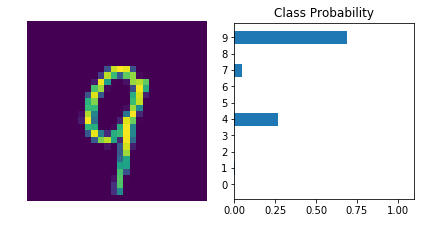

In [47]:
## Testing and evaluation
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Let's iterate through the validation set using a for loop and calculate the total number of correct predictions to calculate the accuracy. 

In [48]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

('Number Of Images Tested =', 10000)
('\nModel Accuracy =', 0)


In [49]:
# Save the trained model for deployed 
torch.save(model.state_dict(),"../data/mnist_cnn.pt")

In [51]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        # fully connected layers 
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
# Create an instance of the Neural Network model
model = ConvNet()

In [52]:
# Loss and optimizer: define the negative log-likelihood loss
criterion = nn.CrossEntropyLoss() #log probabilities
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# clear the gradients, do this to aovid gradients from accumulating
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images) #log probabilities
loss = criterion(output, labels)  #calculate the NLL loss
loss.backward()
print('Gradient -', model[0].weight.grad)

In [ ]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/938], Loss: 0.1465, Accuracy: 0.00%
Epoch [1/5], Step [200/938], Loss: 0.3642, Accuracy: 0.00%
Epoch [1/5], Step [300/938], Loss: 0.1517, Accuracy: 0.00%
Epoch [1/5], Step [400/938], Loss: 0.1271, Accuracy: 0.00%
Epoch [1/5], Step [500/938], Loss: 0.1374, Accuracy: 0.00%
Epoch [1/5], Step [600/938], Loss: 0.0437, Accuracy: 100.00%
Epoch [1/5], Step [700/938], Loss: 0.1724, Accuracy: 0.00%
Epoch [1/5], Step [800/938], Loss: 0.0564, Accuracy: 0.00%
Epoch [1/5], Step [900/938], Loss: 0.0219, Accuracy: 0.00%
Epoch [2/5], Step [100/938], Loss: 0.1914, Accuracy: 0.00%
Epoch [2/5], Step [200/938], Loss: 0.1386, Accuracy: 0.00%
Epoch [2/5], Step [300/938], Loss: 0.2268, Accuracy: 0.00%
Epoch [2/5], Step [400/938], Loss: 0.0334, Accuracy: 0.00%
Epoch [2/5], Step [500/938], Loss: 0.0099, Accuracy: 100.00%
Epoch [2/5], Step [600/938], Loss: 0.0335, Accuracy: 100.00%
Epoch [2/5], Step [700/938], Loss: 0.0158, Accuracy: 0.00%
Epoch [2/5], Step [800/938], Loss: 0.0827, Accurac

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

In [ ]:
# Save the model and plot
MODEL_STORE_PATH='../data/'
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

In [ ]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, push_notebook
from bokeh.models import LinearAxis, Range1d
output_notebook()

In [ ]:
p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p, notebook_handle=True)

In [ ]:
#  At each epoch, we test the model that we have generated
for epoch in range(1, 10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()